# FARSITE Demo

**Complete workflow using satellite fire detections to create ignition polygon**

## Steps:
1. Define fire location and time window
2. **Fetch NASA FIRMS hotspots → Create ignition polygon from first day**
3. Download LANDFIRE landscape data
4. Fetch weather from WIFIRE Firemap
5. Generate landscape file (.lcp)
6. Run FARSITE simulation
7. Visualize results

## Requirements:
- NASA FIRMS API key: https://firms.modaps.eosdis.nasa.gov/api/area/
- Valid email for LANDFIRE
- TestFARSITE and lcpmake in src/

## Setup

In [1]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import contextily as ctx

# Add src to path
DEMO_DIR = Path.cwd()
SRC_DIR = DEMO_DIR / "src"
sys.path.insert(0, str(SRC_DIR))

from data_retrieval import (
    download_landfire_data,
    fetch_weather,
    fetch_firms_hotspots,
    fetch_fire_perimeters,
    generate_lcp_from_rasters
)
from farsite import forward_pass_farsite, forward_pass_farsite_24h

print(f"✓ Demo directory: {DEMO_DIR}")
print(f"✓ Src directory: {SRC_DIR}")

✓ Demo directory: /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo
✓ Src directory: /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/src


## 1. Define Fire Location and Time Window

In [2]:
# Fire identification
FIRE_NAME = "BORDER 2"
FIRE_YEAR = 2025

In [3]:
# Fetch perimeters
perimeters_gdf = fetch_fire_perimeters(FIRE_NAME, FIRE_YEAR)

if perimeters_gdf.empty:
    raise ValueError("No perimeters found!")

# Convert entire GeoDataFrame to WGS84
perimeters_wgs84 = perimeters_gdf.to_crs("EPSG:4326")

# Get centroid of first perimeter
centroid = perimeters_wgs84.iloc[0].geometry.centroid
FIRE_LAT = centroid.y
FIRE_LON = centroid.x

# Time window
first_date = perimeters_gdf['datetime'].min()
last_date = perimeters_gdf['datetime'].max()

# Format as datetime (already datetime objects, but ensure time is set)
FIRE_START = first_date.replace(hour=0, minute=0, second=0)
FIRE_END = last_date.replace(hour=23, minute=59, second=59)

# Weather time window
WEATHER_START = FIRE_START
WEATHER_END = FIRE_START + timedelta(hours=24)

# FARSITE parameters
SIMULATION_DURATION_HOURS = 24

# LANDFIRE parameters
LANDFIRE_RADIUS_MILES = 5
LANDFIRE_EMAIL = "youremail@address.com"  # REPLACE WITH VALID EMAIL ADDRESS

# NASA FIRMS parameters (REQUIRED FOR IGNITION)
FIRMS_MAP_KEY = "YOUR_API_MAP_KEY"  # CREATE YOUR OWN MAP KEY: https://firms.modaps.eosdis.nasa.gov/api/area/
FIRMS_RADIUS_KM = 15
FIRMS_SOURCE = "LANDSAT_NRT"

print(f"Fire location: ({FIRE_LAT}, {FIRE_LON})")
print(f"Weather window: {WEATHER_START} to {WEATHER_END}")
print(f"Simulation: {SIMULATION_DURATION_HOURS} hours")


Querying Firemap WFS for 'BORDER 2' (2025)
  ✓ Retrieved 6 perimeters
  Columns: ['geometry', 'year', 'fire_name', 'agency', 'acres', 'mapmethod', 'inciwebid', 'alarm_date', 'cont_date', 'comments', 'complex_name', 'perimeter_timestamp', 'cause']
  Date range: 2025-01-23 00:00:00 to 2025-01-26 00:00:00
Fire location: (32.595886593540015, -116.85708743001499)
Weather window: 2025-01-23 00:00:00 to 2025-01-24 00:00:00
Simulation: 24 hours


## 2. Fetch FIRMS Hotspots & Create Ignition Polygon

Use first day's satellite detections to define initial fire perimeter.

In [4]:
# Fetch hotspots
hotspots_gdf = fetch_firms_hotspots(
    center_lat=FIRE_LAT,
    center_lon=FIRE_LON,
    radius_km=FIRMS_RADIUS_KM,
    start_date=(WEATHER_START).strftime("%Y-%m-%d"),
    day_range=1,
    source=FIRMS_SOURCE
)

if hotspots_gdf.empty:
    raise ValueError("No FIRMS hotspots found! Check coordinates and API key.")

print(f"\n✓ Found {len(hotspots_gdf)} fire detections")

# Extract first day's hotspots
first_date = hotspots_gdf['datetime'].min().date()
first_day_hotspots = hotspots_gdf[hotspots_gdf['datetime'].dt.date == first_date].copy()

print(f"\nFirst day: {first_date}")
print(f"  Detections: {len(first_day_hotspots)}")

# Create ignition polygon
if len(first_day_hotspots) == 1:
    ignition_poly = first_day_hotspots.geometry.iloc[0].buffer(100)
    print(f"  Created 100m buffer")
elif len(first_day_hotspots) == 2:
    ignition_poly = first_day_hotspots.unary_union.convex_hull.buffer(50)
    print(f"  Created convex hull + 50m buffer")
else:
    # Take only perimeter, not filled area
    ignition_poly = first_day_hotspots.unary_union.convex_hull
    if ignition_poly.is_empty:
        ignition_poly = first_day_hotspots.geometry.iloc[0]

ignition_area_km2 = ignition_poly.area / 1e6
print(f"  Ignition area: {ignition_area_km2:.3f} km²")

# Set simulation start
SIMULATION_START = first_day_hotspots['datetime'].min() + timedelta(hours=1)
print(f"  Simulation start: {SIMULATION_START}")


Querying FIRMS hotspots near (32.595886593540015, -116.85708743001499)
  ✓ Retrieved 32 high-confidence detections

✓ Found 32 fire detections

First day: 2025-01-23
  Detections: 32
  Ignition area: 187.835 km²
  Simulation start: 2025-01-23 19:22:00


/tmp/ipykernel_19086/2824483612.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ignition_poly = first_day_hotspots.unary_union.convex_hull


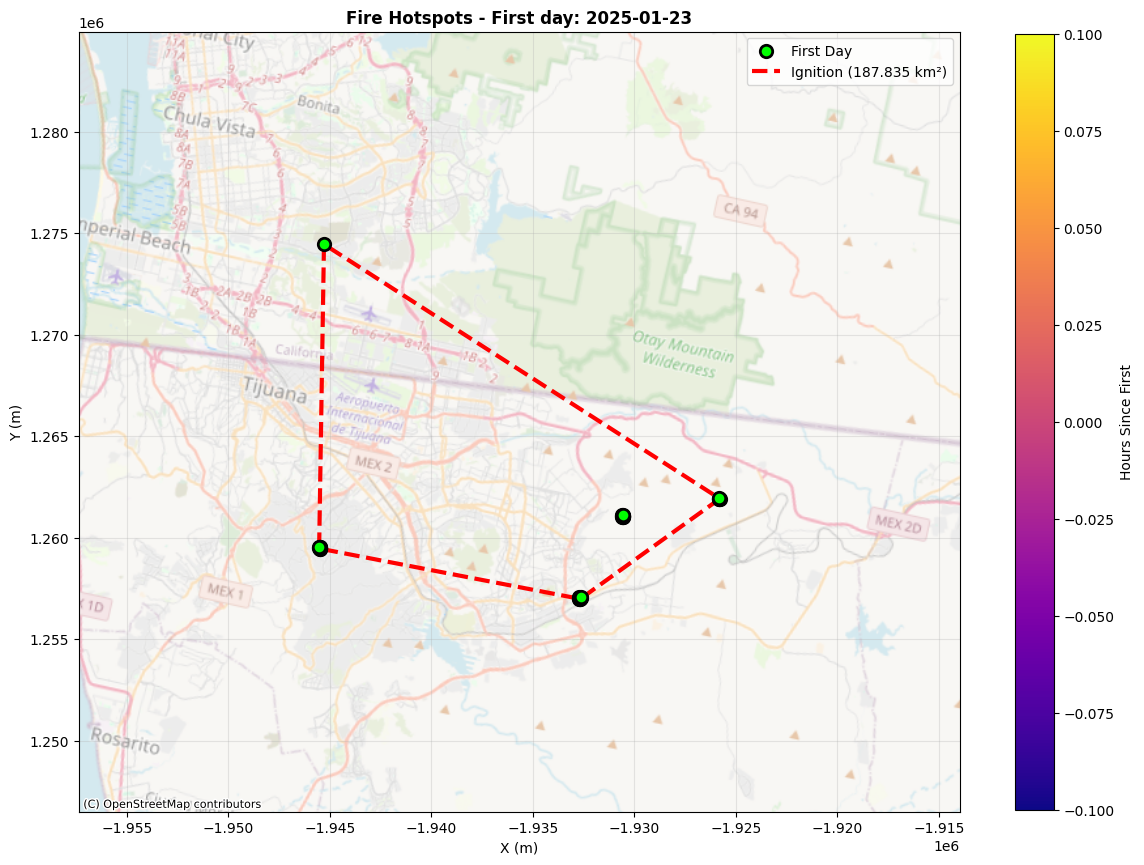

In [5]:
# Visualize hotspots and ignition polygon
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

hotspots_gdf['hours_since_first'] = (
    hotspots_gdf['datetime'] - hotspots_gdf['datetime'].min()
).dt.total_seconds() / 3600

# Plot hotspots
hotspots_gdf.plot(
    ax=ax, column='hours_since_first', cmap='plasma',
    markersize=40, alpha=0.7, edgecolor='white', linewidth=1,
    legend=True, legend_kwds={'label': 'Hours Since First', 'shrink': 0.8}
)

# Expand for basemap
xlim, ylim = ax.get_xlim(), ax.get_ylim()
x_margin = (xlim[1] - xlim[0]) * 0.5
y_margin = (ylim[1] - ylim[0]) * 0.5
ax.set_xlim(xlim[0] - x_margin, xlim[1] + x_margin)
ax.set_ylim(ylim[0] - y_margin, ylim[1] + y_margin)

# Basemap
try:
    ctx.add_basemap(
        ax, crs=hotspots_gdf.crs.to_string(),
        source=ctx.providers.OpenStreetMap.Mapnik,
        zoom='auto', alpha=0.5, zorder=0
    )
    hotspots_gdf.plot(
        ax=ax, column='hours_since_first', cmap='plasma',
        markersize=40, alpha=0.7, edgecolor='white', linewidth=1
    )
except:
    pass

# First day hotspots
first_day_hotspots.plot(
    ax=ax, color='lime', markersize=80,
    edgecolor='black', linewidth=2,
    label='First Day', zorder=10
)

# Ignition polygon
gpd.GeoSeries([ignition_poly], crs=hotspots_gdf.crs).boundary.plot(
    ax=ax, color='red', linewidth=3, linestyle='--',
    label=f'Ignition ({ignition_area_km2:.3f} km²)', zorder=9
)

ax.set_title(f'Fire Hotspots - First day: {first_date}', fontweight='bold')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
print("CRS Check:")
print(f"FIRMS hotspots CRS: {first_day_hotspots.crs}")
print(f"Perimeters CRS: {perimeters_gdf.crs}")
print(f"Match: {first_day_hotspots.crs == perimeters_gdf.crs}")

# Check bounds
print(f"\nFIRMS bounds: {first_day_hotspots.total_bounds}")
print(f"Perimeter bounds: {perimeters_gdf.total_bounds}")

# Sanity check - convert a point back to WGS84
firms_wgs84 = first_day_hotspots.to_crs("EPSG:4326")
perim_wgs84 = perimeters_gdf.to_crs("EPSG:4326")

print(f"\nFIRMS in WGS84: {firms_wgs84.iloc[0].geometry}")
print(f"Perimeter in WGS84: {perim_wgs84.iloc[0].geometry.centroid}")
print(f"\nOriginal input: ({FIRE_LAT}, {FIRE_LON})")

CRS Check:
FIRMS hotspots CRS: EPSG:5070
Perimeters CRS: EPSG:5070
Match: True

FIRMS bounds: [-1945522.35501995  1256979.14041248 -1925802.75726742  1274445.39791374]
Perimeter bounds: [-1935891.52067626  1270171.48083928 -1929222.09165391  1277242.45308854]

FIRMS in WGS84: POINT (-116.97866399999998 32.467123999999984)
Perimeter in WGS84: POINT (-116.85708743001499 32.595886593540015)

Original input: (32.595886593540015, -116.85708743001499)


### Fetch Observed Fire Perimeters

Get actual mapped perimeters from Firemap for comparison with FARSITE predictions.

In [7]:
# Fetch fire perimeters from Firemap
perimeters_gdf = fetch_fire_perimeters(FIRE_NAME, FIRE_YEAR)

if not perimeters_gdf.empty:
    print(f"\nFound {len(perimeters_gdf)} mapped perimeters")
    
    # Find perimeter closest to simulation end time for validation
    sim_end = SIMULATION_START + timedelta(hours=SIMULATION_DURATION_HOURS)
    time_diffs = abs(perimeters_gdf['datetime'] - sim_end)
    closest_idx = time_diffs.idxmin()
    
    validation_perim = perimeters_gdf.iloc[closest_idx]
    validation_date = validation_perim['datetime']
    validation_poly = validation_perim.geometry
    validation_area_km2 = validation_poly.area / 1e6
    
    print(f"\nValidation perimeter (closest to simulation end):")
    print(f"  Date: {validation_date}")
    print(f"  Area: {validation_area_km2:.3f} km²")
    print(f"  Time delta from sim end: {abs((validation_date - sim_end).total_seconds() / 3600):.1f} hours")
else:
    print("\n⚠ No perimeters found in Firemap")
    validation_poly = None



Querying Firemap WFS for 'BORDER 2' (2025)
  ✓ Retrieved 6 perimeters
  Columns: ['geometry', 'year', 'fire_name', 'agency', 'acres', 'mapmethod', 'inciwebid', 'alarm_date', 'cont_date', 'comments', 'complex_name', 'perimeter_timestamp', 'cause']
  Date range: 2025-01-23 00:00:00 to 2025-01-26 00:00:00

Found 6 mapped perimeters

Validation perimeter (closest to simulation end):
  Date: 2025-01-24 00:00:00
  Area: 17.138 km²
  Time delta from sim end: 19.4 hours


## 3. Download LANDFIRE Data

In [8]:
rasters = download_landfire_data(
    center_lat=FIRE_LAT,
    center_lon=FIRE_LON,
    radius_miles=LANDFIRE_RADIUS_MILES,
    output_dir="data/landfire"
)

Radius: 5 miles
Bounding box: [-116.9428, 32.5233, -116.7713, 32.6685]

Submitting LANDFIRE request...
✓ Job ID: c7c40451-4142-479e-9e8e-eb60e5d59434

Waiting for LANDFIRE processing...
  [0s] pending
  [11s] executing
  [21s] succeeded

✓ Completed in 21s
Downloading...
Extracting...

Converting to ASCII...


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CBD.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CBH.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CC.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CH.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250FBFM40.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ ASP2020.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ ELEV2020.asc
  ✓ SLPP2020.asc

✓ LANDFIRE data downloaded


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


## 4. Fetch Weather Data

In [9]:
weather = fetch_weather(
    lat=FIRE_LAT,
    lon=FIRE_LON,
    start_dt=SIMULATION_START,
    end_dt=SIMULATION_START + timedelta(hours=24)
)

print(f"Wind: {weather['windspeed']:.1f} mph @ {weather['winddirection']:.0f}°")


Querying weather near (32.595886593540015, -116.85708743001499)
✓ Mean wind: 9.5 mph @ 82°
Wind: 9.5 mph @ 82°


## 5. Generate Landscape File

In [10]:
lcp_path = generate_lcp_from_rasters(
    output_path="data/landscape.lcp",
    elevation_asc=rasters['elevation'],
    slope_asc=rasters['slope'],
    aspect_asc=rasters['aspect'],
    fuel_asc=rasters['fuel'],
    canopy_cover_asc=rasters['canopy_cover'],
    canopy_height_asc=rasters['canopy_height'],
    canopy_base_asc=rasters['canopy_base'],
    canopy_density_asc=rasters['canopy_density'],
    latitude=FIRE_LAT
)


Running lcpmake...
Command: /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/src/lcpmake -latitude 32.595886593540015 -landscape data/landscape -elevation data/landfire/ELEV2020.asc -slope data/landfire/SLPP2020.asc -aspect data/landfire/ASP2020.asc -fuel data/landfire/250FBFM40.asc -cover data/landfire/250CC.asc -height data/landfire/250CH.asc -base data/landfire/250CBH.asc -density data/landfire/250CBD.asc -fb40
lcpmake stdout: -----------------------------------
-----------------------------------

LCPMake processing grid themes.....

-----------------------------------
-----------------------------------

Size of header data:7316


LCPMAKE.EXE Completed......

Landscape File Generated:

>>>>  data/landscape.lcp



✓ Landscape file created: data/landscape.lcp


## 6. Run FARSITE Simulation

In [11]:
params = {
    'windspeed': int(weather['windspeed']),
    'winddirection': int(weather['winddirection']),
    'lat': FIRE_LAT,
    'lon': FIRE_LON, 
    'dt': timedelta(hours=24)
}

print(f"Running FARSITE...")
print(f"  Ignition: {ignition_area_km2:.3f} km²")
print(f"  Start: {SIMULATION_START}")
print(f"  Duration: {SIMULATION_DURATION_HOURS} hours")
print(f"  Timestep: 6 hours")
print(f"  Wind: {params['windspeed']} mph @ {params['winddirection']}°")

# Use 24h function for multi-timestep simulation
result_poly = forward_pass_farsite_24h(
    poly=ignition_poly,
    params=params,
    start_time=SIMULATION_START,
    lcppath=lcp_path,
    simulation_hours=SIMULATION_DURATION_HOURS
)

if result_poly is not None:
    # Convert to GeoDataFrame for visualization
    result = gpd.GeoDataFrame(
        {'geometry': [result_poly]},
        crs="EPSG:5070"
    )
    
    final_area_km2 = result_poly.area / 1e6
    growth_km2 = final_area_km2 - ignition_area_km2
    print(f"\n✓ FARSITE completed")
    print(f"  Initial: {ignition_area_km2:.3f} km²")
    print(f"  Final: {final_area_km2:.3f} km²")
    print(f"  Growth: {growth_km2:.3f} km² (+{growth_km2/ignition_area_km2*100:.1f}%)")
else:
    result = None
    print("⚠ FARSITE simulation failed")


Running FARSITE...
  Ignition: 187.835 km²
  Start: 2025-01-23 19:22:00
  Duration: 24 hours
  Timestep: 6 hours
  Wind: 9 mph @ 82°
Using fuel moisture for January 2025: 1h=4%, 10h=5%, 100h=6%, herb=60%, wood=90%
Starting simulation: 24.0 hours in 30-min steps
Step 1: 24.0h remaining, running 30min
  → Area: 0.000 km²
Step 2: 23.5h remaining, running 30min
  → Area: 0.000 km²
Step 3: 23.0h remaining, running 30min
  → Area: 0.000 km²
Step 4: 22.5h remaining, running 30min
  → Area: 0.000 km²
Step 5: 22.0h remaining, running 30min
  → Area: 0.000 km²
Step 6: 21.5h remaining, running 30min
  → Area: 0.000 km²
Step 7: 21.0h remaining, running 30min
  → Area: 0.000 km²
Step 8: 20.5h remaining, running 30min
  → Area: 0.000 km²
Step 9: 20.0h remaining, running 30min
  → Area: 0.000 km²
Step 10: 19.5h remaining, running 30min
  → Area: 0.000 km²
Step 11: 19.0h remaining, running 30min
  → Area: 0.000 km²
Step 12: 18.5h remaining, running 30min
  → Area: 0.000 km²
Step 13: 18.0h remaining, r

## 7. Visualize Results

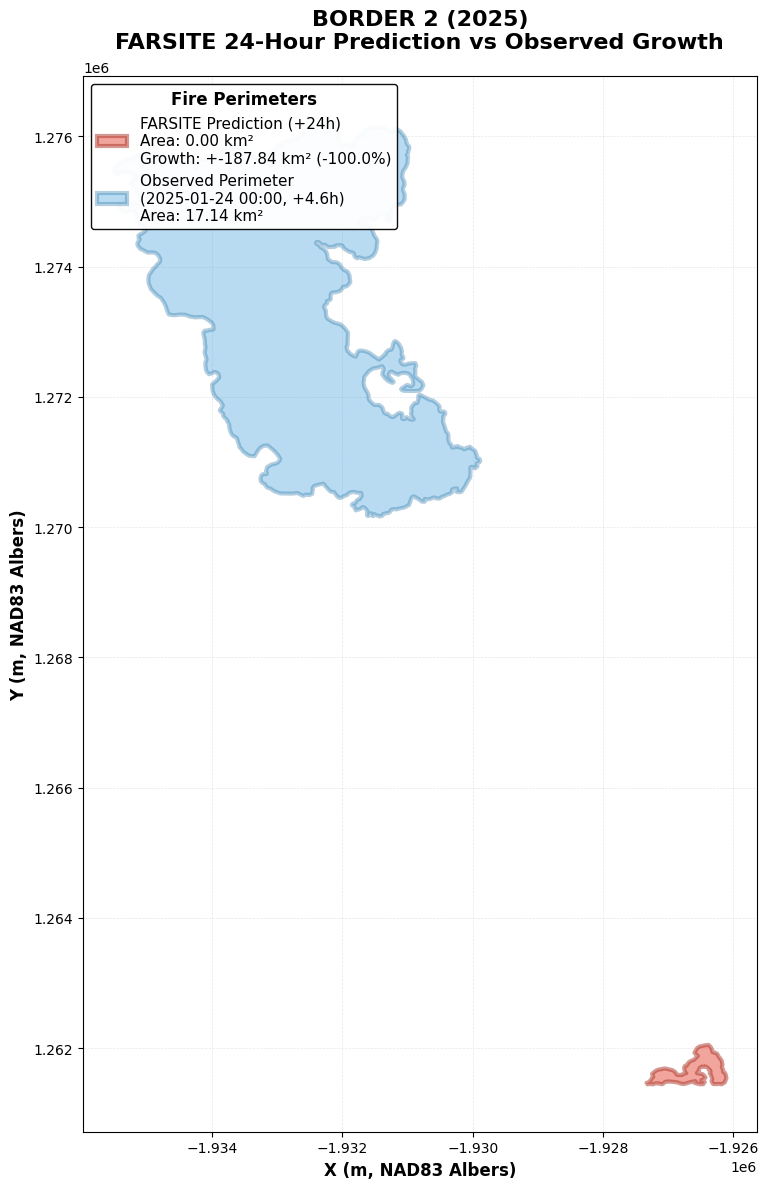


FARSITE SIMULATION RESULTS - BORDER 2 (2025)

INITIAL CONDITIONS:
  Start Time:           2025-01-23 19:22 UTC
  Initial Area:         187.835 km²
  Wind Speed:           9 mph
  Wind Direction:       82°
  Simulation Duration:  24 hours

FARSITE PREDICTION:
  Final Area:           0.000 km²
  Area Growth:          -187.835 km²
  Percent Increase:     -100.0%

OBSERVED (GROUND TRUTH):
  Observation Time:     2025-01-24 00:00 UTC
  Final Area:           17.138 km²
  Area Growth:          -170.698 km²
  Percent Increase:     -90.9%

PREDICTION ACCURACY:
  Area Error:           -17.138 km²
  Percent Error:        -100.0%

SPATIAL OVERLAP:
  Intersection/Union:   0.000
  Overlap Area:         0.000 km²
  Coverage:             0.0% of observed



In [12]:
if result is not None:
    from matplotlib.patches import Patch
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    
    # Plot layers from back to front (WITHOUT labels first)
    
    # 1. Validation perimeter (observed - blue)
    if 'validation_poly' in locals() and validation_poly:
        hours_diff = (validation_date - SIMULATION_START).total_seconds() / 3600
        gpd.GeoSeries([validation_poly], crs="EPSG:5070").plot(
            ax=ax, 
            facecolor='#3498db',
            edgecolor='#2874a6', 
            alpha=0.35, 
            linewidth=3,
            zorder=3
        )
    

    
    
    # 3. FARSITE prediction (red)
    gpd.GeoSeries([result_poly], crs="EPSG:5070").plot(
        ax=ax, 
        facecolor='#e74c3c',
        edgecolor='#a93226', 
        alpha=0.5, 
        linewidth=3,
        zorder=4
    )
    
    # Create custom legend entries
    legend_elements = [
        Patch(facecolor='#e74c3c', edgecolor='#a93226', alpha=0.5, linewidth=3,
              label=f'FARSITE Prediction (+{SIMULATION_DURATION_HOURS}h)\nArea: {final_area_km2:.2f} km²\nGrowth: +{growth_km2:.2f} km² ({growth_km2/ignition_area_km2*100:.1f}%)')
    ]
    
    if 'validation_poly' in locals() and validation_poly:
        hours_diff = (validation_date - SIMULATION_START).total_seconds() / 3600
        legend_elements.insert(2, Patch(facecolor='#3498db', edgecolor='#2874a6', alpha=0.35, linewidth=3,
              label=f'Observed Perimeter\n({validation_date.strftime("%Y-%m-%d %H:%M")}, +{hours_diff:.1f}h)\nArea: {validation_area_km2:.2f} km²'))
    
    # Title and labels
    ax.set_title(
        f'{FIRE_NAME} ({FIRE_YEAR})\n'
        f'FARSITE {SIMULATION_DURATION_HOURS}-Hour Prediction vs Observed Growth',
        fontsize=16, 
        fontweight='bold',
        pad=20
    )
    
    ax.set_xlabel('X (m, NAD83 Albers)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y (m, NAD83 Albers)', fontsize=12, fontweight='bold')
    
    # Add custom legend
    legend = ax.legend(
        handles=legend_elements,
        loc='upper left', 
        fontsize=11,
        framealpha=0.95,
        edgecolor='black',
        title='Fire Perimeters',
        title_fontsize=12
    )
    legend.get_title().set_fontweight('bold')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.tick_params(labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\n{'='*80}")
    print(f"FARSITE SIMULATION RESULTS - {FIRE_NAME} ({FIRE_YEAR})")
    print(f"{'='*80}")
    print(f"\nINITIAL CONDITIONS:")
    print(f"  Start Time:           {SIMULATION_START.strftime('%Y-%m-%d %H:%M UTC')}")
    print(f"  Initial Area:         {ignition_area_km2:.3f} km²")
    print(f"  Wind Speed:           {params['windspeed']} mph")
    print(f"  Wind Direction:       {params['winddirection']}°")
    print(f"  Simulation Duration:  {SIMULATION_DURATION_HOURS} hours")
    
    print(f"\nFARSITE PREDICTION:")
    print(f"  Final Area:           {final_area_km2:.3f} km²")
    print(f"  Area Growth:          {growth_km2:.3f} km²")
    print(f"  Percent Increase:     {growth_km2/ignition_area_km2*100:.1f}%")
    
    if 'validation_poly' in locals() and validation_poly:
        obs_growth = validation_area_km2 - ignition_area_km2
        error = final_area_km2 - validation_area_km2
        error_pct = (error / validation_area_km2) * 100
        
        print(f"\nOBSERVED (GROUND TRUTH):")
        print(f"  Observation Time:     {validation_date.strftime('%Y-%m-%d %H:%M UTC')}")
        print(f"  Final Area:           {validation_area_km2:.3f} km²")
        print(f"  Area Growth:          {obs_growth:.3f} km²")
        print(f"  Percent Increase:     {obs_growth/ignition_area_km2*100:.1f}%")
        
        print(f"\nPREDICTION ACCURACY:")
        print(f"  Area Error:           {error:+.3f} km²")
        print(f"  Percent Error:        {error_pct:+.1f}%")
        
        # Spatial overlap
        try:
            intersection = result_poly.intersection(validation_poly)
            union = result_poly.union(validation_poly)
            iou = intersection.area / union.area if union.area > 0 else 0
            overlap_pct = (intersection.area / validation_area_km2) * 100 if validation_area_km2 > 0 else 0
            
            print(f"\nSPATIAL OVERLAP:")
            print(f"  Intersection/Union:   {iou:.3f}")
            print(f"  Overlap Area:         {intersection.area/1e6:.3f} km²")
            print(f"  Coverage:             {overlap_pct:.1f}% of observed")
        except:
            pass
    
    print(f"{'='*80}\n")
else:
    print("⚠ No FARSITE results to visualize")